# $\mathrm{RESOLVE \space UNIT \space \beta}$
## 周波数領域電磁探査法(RESOLVE)データの深層学習を用いた水平多層構造解析
入力セルを編集後、全てのセルを実行してください。

## 各種ライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import sys, os
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from script import ModelingToolKit as mtk
from script import Dataset as ds

plt.rcParams["font.size"] = 18
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

## 入力セル

In [65]:
#プロジェクトフォルダ名
pjdir_name = 'sample'

"""
層厚の設定
　学習データの生成から地下構造の内、層数と層厚は固定されます。
　入力値は層数、表層の厚さ、最終層の上端深度、層厚の等分割スケールの４つです。
　全n層の内、表層と最終層の間は線形スケールまたは対数スケールで(n-2)等分されます。
　一層ずつ手入力で決めることもできます。
"""
# manual
# thickness = []
# semi-auto
thickness = mtk.tmake(0.5, 150, 30, scale='log')

"""
人口学習データの生成とRESOLVEに関する設定
"""
# 学習に用いる比抵抗構造-磁場応答データの数
dataset_size = 10000

# 生成する比抵抗の範囲 (Ohm-m)
resistivity_range = [10, 1000]

# バード高さの上限下限 (m)
bird_height_range = [10, 100]

# RESOLVEの測定周波数(降順, Hz)
freqs = [140000, 31000, 6600, 3300, 1500, 340]

# 各コイルの送受信間隔 (m)
spans = [7.86, 7.86, 7.86, 8.99, 7.86, 7.86]

# ノイズの付与　on : = True, off : = False
add_noise = True

# ノイズレベル（付与するノイズの標準偏差, ppm)
noise_level = [50, 40, 30, 20, 10, 10]

# 比抵抗構造生成モード 現状、'normal'で固定
generate_mode = 'normal'


"""
ニューラルネットワークの学習に関する設定
"""

# バッチサイズ　値が大きいほど学習時間は短くなります。
batch_size = 400
# エポック回数 値が小さいほど学習時間が短くなります。
epochs = 50

"""
深層学習解析を適用するフィールドデータの入力
"""
# 探査プロジェクト名（自由）
field_name = 'sendai_plains'
# データは表形式
# CSV / XYZ から選べる
field_data_format = 'CSV'

# フィールドデータのファイルのパス
data_dir = "database/survey/HEM_line_base_mini.csv"

save_dir = "database/result/" + field_name + "_" + dnn_name + ".csv"

# TXTの場合の冒頭スキップ行数
skiprows = 8

# 使用するデータ列の列番号
#  測線番号, Easting (m), Northing (m), 地表面標高 (m), HCP5種同相成分 (ppm), HCP5種離相成分 (ppm), バード高さ
#  ※ 同相成分、離相成分は周波数の昇順にします。
#  ※ 3300HzVCAコイルのデータは除外することに注意してください。
pickup_columns = [
    
]

# 測定データファイルの欠損オブジェクト
nan_char =['*']

In [ ]:
# プロジェクトフォルダの新規作成


## 1. 層構造の決定

層境界深度 (m)
  0.000 |   0.500 |   0.613 |   0.751 |   0.921 |   1.129 |   1.385 |   1.697 |   2.081 |   2.551 | 
  3.127 |   3.834 |   4.700 |   5.762 |   7.064 |   8.660 |  10.617 |  13.016 |  15.956 |  19.562 | 
 23.981 |  29.400 |  36.042 |  44.185 |  54.169 |  66.407 |  81.411 |  99.805 | 122.355 | 150.000 | 
層厚 (m)
  0.500 |   0.113 |   0.138 |   0.170 |   0.208 |   0.255 |   0.313 |   0.384 |   0.470 |   0.576 | 
  0.707 |   0.866 |   1.062 |   1.302 |   1.596 |   1.957 |   2.399 |   2.941 |   3.605 |   4.420 | 
  5.418 |   6.643 |   8.143 |   9.983 |  12.239 |  15.004 |  18.394 |  22.550 |  27.645 | 

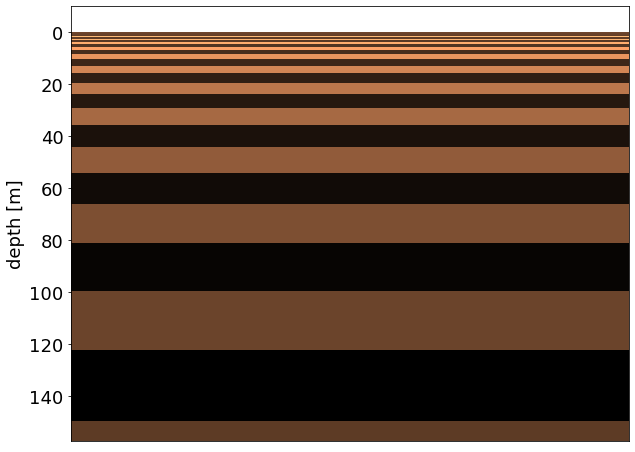

In [66]:
depth = mtk.dmake(thickness)
print('層境界深度 (m)')
for i in range(len(depth)):
    if (i+1) % 10 == 0:
        eol = ' | \n'
    else:
        eol = ' | '
    char = "{:7,.3f}".format(depth[i])
    print(char ,end=eol)
print('層厚 (m)')
for i in range(len(thickness)):
    if (i+1) % 10 == 0:
        eol = ' | \n'
    else:
        eol = ' | '
    char = "{:7,.3f}".format(thickness[i])
    print(char ,end=eol)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
x = np.array([0,1])
y = np.array([*depth, 1.05*depth[-1]])
z = np.log(np.array([depth]).T + 10)
ld = len(depth)
m = ld // 2
for i in range(m):
    z[2*i,0] *= 2
z = 1/z
ax.pcolormesh(x,y,z,cmap='copper')
ax.set_ylabel('depth [m]')
ax.set_ylim(-10, y[-1])
ax.invert_yaxis()
ax.axes.xaxis.set_ticks([])
plt.show()

## 2. データ生成

In [ ]:
# 設定の保存
settings = {
    'pjdir_name' : pjdir_name,
    'depth' : [*depth],
    'thickness' : [*thickness],
    'dataset_size' : dataset_size,
    'resistivity_range' : resistivity_range,
    'bird_height_range' : bird_height_range,
    'frequency' : freqs,
    'separetion' : spans,
    'add_noise' : add_noise,
    'noise_level' : noise_level,
    'generate_mode' : generate_mode,
    'batch_size' : batch_size,
    'epochs' : epochs,
    'field_name' : field_name,
    'datafile_format' : datafile_format,
    'data_directory' : data_directory,
    'skiprows' : skiprows,
    'pickup_columns' : pickup_columns,
    'nan_char' : nan_char,
    'save_path' : save_path
}
with open('database/result/{}_{}_settings.json'.format(field_name, dnn_name), 'w') as fp:
    json.dump(settings, fp)

config = {
    'thicks' : thicks,
    'rmean' : np.log10(res_mean),
    'rscat' : 1.0,
    'height_range' : (height_min, height_max),
    'freqs' : freqs,
    'span' : offset,
    'add_noise' : add_noise,
    'noise_level' : noise_level,
    'random_mode' : generate_mode
}

In [ ]:
nlayer = len(depth)

dataset_dir = 'database/dataset/'
dsetfile_path = dataset_dir + dnn_name + '_{}_{}.csv'.format(nlayer, size)

model_dir = 'model/'
histfile_path = model_dir + 'history/' + dnn_name + 'history.csv'
nnetfile_path = model_dir + 'network/' + dnn_name + 'network.h5'


if os.path.exists(dsetfile_path):
    df = pd.read_csv(dsetfile_path, header=None)
    print('Datasets already exist')
else:
    resolve = em.Resolve1D(**config)
    data = resolve.multi_process(size, parallel_num)
    df = pd.DataFrame(data)
    df.to_csv(dsetfile_path, header=None, index=False)
    print("-> /" + dsetfile_path)


## 3. ニューラルネットワークの学習

In [ ]:
#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()

#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [ ]:
if os.path.exists(nnetfile_path):
    print('The Specified Neural Network Model Already Exists.')
    network = load_model(nnetfile_path)
    hist_df = pd.read_csv(histfile_path)
else:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_path)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_path)


## 4. 評価・テスト

In [ ]:
plt.rcParams["font.size"] = 18
plt.tight_layout()
epochx = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
ax1.plot(epochx, loss, label='train loss', linewidth=2)
ax1.plot(epochx, val_mse, label='validation loss', linewidth=2)
ax1.set_xlabel('epochs')
ax1.set_ylabel('MSE')
ax1.set_xlim(0, epochx.max())
ax1.set_ylim(0, loss.max() // 1 + 1)
ax1.legend()
ax1.grid()
ax1.set_title('Loss Transition', fontsize = 20)

terr = (y_test - network.predict(x_test))**2
res_mse = np.array([k.mean() for k in terr])

ax2 = fig.add_subplot(122)
max_mse = res_mse.max()
nbins = int(max_mse // 0.1)
bins = [.1*(i) for i in range(nbins)]
n, bins, patches = ax2.hist(res_mse, bins=bins, edgecolor='k')
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax2.set_xlabel('MSE')
ax2.set_ylabel('number of data')
mean = np.mean(res_mse)
median = np.median(res_mse)
ax2.set_ylim(0, n.max()+10)
ax2.set_title('Mean: {mean:.2f}, Median: {median:.2f}'.format(mean=mean, median=median))

# 第2軸のプロット
bx2 = ax2.twinx()
lines = bx2.plot(x2, y2, ls='-', color='C1', linewidth=3, label='Cumulative ratio')
bx2.set_ylim(10 * y2.min() // 10, 105)
bx2.set_ylabel('Cumulative ratio [%]')
bx2.legend();

In [ ]:
sys.path.append('../../')
from script import myviz as viz
true_res = 10 ** y_test
pred_res = 10 ** network.predict(x_test)
orig_emf = x_test_org[:, :10]
height = x_test_org[:, 10]

test_data_size = len(y_test)
index = np.random.randint(0, test_data_size)

true_res = true_res[index]
pred_res = pred_res[index]
height = height[index]
orig_emf = orig_emf[index]

cfreq_range = (0, 8)
print(index)

fig = viz.resolve.sumplot(
    thicks, pred_res, true_res, height, offset, freqs, cfreq_range, orig_emf, noised=add_noise, log_depth=True
)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.axes[0].set_yscale('log');

## 5. DL解析

In [ ]:
for i in range(len(pickup_columns)):
    pickup_columns[i] -= 1

header = ['line No.', 'easting', 'northing', 'elevation', 'EM1R', 'EM2R', 'EM3R', 'EM4R', 'EM5R', 'EM1I', 'EM2I', 'EM3I', 'EM4I', 'EM5I', 'bird_height']
dnnx_index = ['EM1R', 'EM2R', 'EM3R', 'EM4R', 'EM5R', 'EM1I', 'EM2I', 'EM3I', 'EM4I', 'EM5I', 'bird_height']
loc_index = ['line No.', 'easting', 'northing', 'elevation']

if os.path.exists(save_path):
    print('the result has already saved.')
    pass

else:
    if datafile_format == 'XYZ':
        data = np.loadtxt(data_directory, skiprows=skiprows)
        dfd = data[:, pickup_columns]
        df = pd.DataFrame(dfd, columns=header)

    elif datafile_format == 'CSV':
        data = pd.read_csv(data_directory)
        dfd = data.iloc[:, pickup_columns].values
        df = pd.DataFrame(dfd, columns=header)

    # 欠損値を含む行
    df = df.replace(nan_char, np.nan)
    df = df.dropna(how='any')
    x = df[dnnx_index].values
    loc = df[loc_index].values

    stdx = sc.transform(x)
    res = network.predict(stdx)
    res = 10 ** res

    numlayer = len(depth)
    res_header = ['R{}'.format(i+1) for i in range(numlayer)]
    header = [*header, *res_header]
    rdata = np.hstack([loc, x, res])
    rdf = pd.DataFrame(rdata)
    rdf.to_csv(save_path, header=header, index=False)
    print('the result is saved at ' + save_path)

In [ ]:
df = pd.read_csv(save_path)
lines = df['line No.'].values
line_no_list = []
logg = 0
for nomb in lines:
    if nomb == logg:
        logg = nomb
    else:
        line_no_list.append(nomb)
        logg = nomb
print('測線番号リスト')
print(line_no_list)


## 6. 比抵抗断面図の作成

In [ ]:
lineno = line_no_list[3]

dfch = df[df['line No.']==lineno]
emdfx = dfch.loc[:, 'easting':'bird_height']
redfx = dfch.loc[:, 'R1':]

easting = emdfx['easting'].values
nrothing = emdfx['northing'].values
elevation = emdfx['elevation'].values
height = emdfx['bird_height'].values

res = redfx.values
res = np.log10(res)

resmax = np.log10(1000)
resmin = res.min()
cres = (res-resmin)/(resmax-resmin)
cmaps = plt.cm.jet_r(cres)

depthadd = np.append(depth, 2*depth.max())
plt.style.use('default')
fig = plt.figure(figsize=(20, 3), dpi=100)
ax = fig.add_subplot(111)
ax.grid()
ax.set(xlim=(easting.min(), easting.max()), ylim=(-depth.max()+elevation.min()-50, height.max()+100))
for i in range(easting.shape[0]-1):
    mesh_x, mesh_y = np.meshgrid(easting[i:i+2], -depthadd+elevation[i])
    cross_section = ax.pcolormesh(mesh_x, mesh_y, res[i].reshape(len(res[i]), 1), vmin=resmin, vmax=resmax, cmap='jet_r', shading='flat')

norm = mpl.colors.Normalize(vmin=resmin, vmax=resmax)
m = mpl.cm.ScalarMappable(cmap=plt.cm.jet_r, norm=norm)
m.set_array([])
fig.colorbar(m, label='Resistivity ${\log_{10}{ρ}}$')
ax.plot(easting, elevation+height, color='k', label='bird')
ax.legend()
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Elevation [m]')
ax.set_title('Resistivity Structure below the Line No.{}'.format(lineno));